##  Import libraries

In [1]:
import os
import csv
from random import choice
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
from sklearn.metrics import f1_score

import albumentations
from albumentations.pytorch import ToTensorV2

d:\programMe\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda:0')

## Help objects

In [3]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None, use_albumentations=False):
        self.transform = transform
        self.folder = folder
        self.name_data = os.listdir(folder)
        self.use_albumentations = use_albumentations
    def __len__(self):
        return len(self.name_data)
    
    def __getitem__(self, index):        
        img_id = self.name_data[index]
        img = Image.open(os.path.join(self.folder, img_id))
        
        frame = img_id.find('_')
        name = img_id[:frame]
        y = 0
        if name in (set(['frankfurter', 'chili-dog', 'hotdog'])):
            y = 1

        if self.transform:
            if self.use_albumentations:
                image = self.transform(image=np.array(img))
                img = image['image']
            else:
                img = self.transform(img)
            
    
        return img, y, img_id

In [4]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

In [5]:
def compute_accuracy_and_f1(model, loader):
    model.eval()
    
    correct_samples = 0
    total_samples = 0
    total_f1 = 0
    y_full = []
    prediction_full = []
    for _, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
        y_full.extend(y.tolist())
        prediction_full.extend(indices.tolist())
    val_accuracy = float(correct_samples) / total_samples
    total_f1 = f1_score(y_full, prediction_full)
    
    return val_accuracy, total_f1

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    val_f1_history = []
    for epoch in range(num_epochs):
        print(f'--Epoch {epoch+1}/{num_epochs}, lr = {scheduler.get_last_lr()[-1]}')
        
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_f1 = compute_accuracy_and_f1(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        val_f1_history.append(val_f1)
        
        print("----Average loss: %f, Train accuracy: %f, Val accuracy: %f, Val f1 score: %f" % (ave_loss, train_accuracy, val_accuracy, val_f1))
        
    return loss_history, train_history, val_history, val_f1_history

In [7]:
def evaluate_model(model, loader):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    """
    model.eval() # Evaluation mode
    
    image_id = []
    predictions = []
    
    for (x, _, id_img) in loader:
        
        image_id.extend(id_img)
        x_gpu = x.to(device)
        predict = torch.argmax(model(x_gpu), 1)
        predictions.extend(predict.tolist())
            
    return predictions, image_id

## Load and prepaire data

In [8]:
tfs_for_vis = albumentations.Compose([
    albumentations.RandomRotate90(p=0.3),
    albumentations.Blur(p=0.1),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.GaussNoise(p=0.3),
    albumentations.ShiftScaleRotate(p=0.3),
    albumentations.ImageCompression(quality_lower=90, p=0.3),
    ])

tfs = albumentations.Compose([
    albumentations.RandomRotate90(p=0.3),
    albumentations.Blur(p=0.1),
    albumentations.RandomBrightnessContrast(p=0.3),
    albumentations.GaussNoise(p=0.3),
    albumentations.ShiftScaleRotate(p=0.3),
    albumentations.ImageCompression(quality_lower=90, p=0.3),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])
tfs_test_2 = albumentations.Compose([
    albumentations.RandomRotate90(p=0.7),
    albumentations.Blur(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.7),
    albumentations.GaussNoise(p=0.1),
    albumentations.ShiftScaleRotate(p=0.1),
    albumentations.ImageCompression(quality_lower=90, p=0.1),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])
tfs_test_3 = albumentations.Compose([
    albumentations.RandomRotate90(p=0.1),
    albumentations.Blur(p=0.1),
    albumentations.RandomBrightnessContrast(p=0.1),
    albumentations.GaussNoise(p=0.7),
    albumentations.ShiftScaleRotate(p=0.7),
    albumentations.ImageCompression(quality_lower=90, p=0.7),
    albumentations.Resize(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ])

In [9]:
dataset = HotdogOrNotDataset('data/train', transform=tfs_for_vis, use_albumentations=True)
train_dataset = HotdogOrNotDataset('data/train', transform=tfs, use_albumentations=True)
test_dataset = HotdogOrNotDataset('data/test', 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                           ])
                       )

In [10]:
test_dataset_2 = HotdogOrNotDataset('data/test', transform=tfs_test_2, use_albumentations=True)
test_dataset_3 = HotdogOrNotDataset('data/test', transform=tfs_test_3, use_albumentations=True)

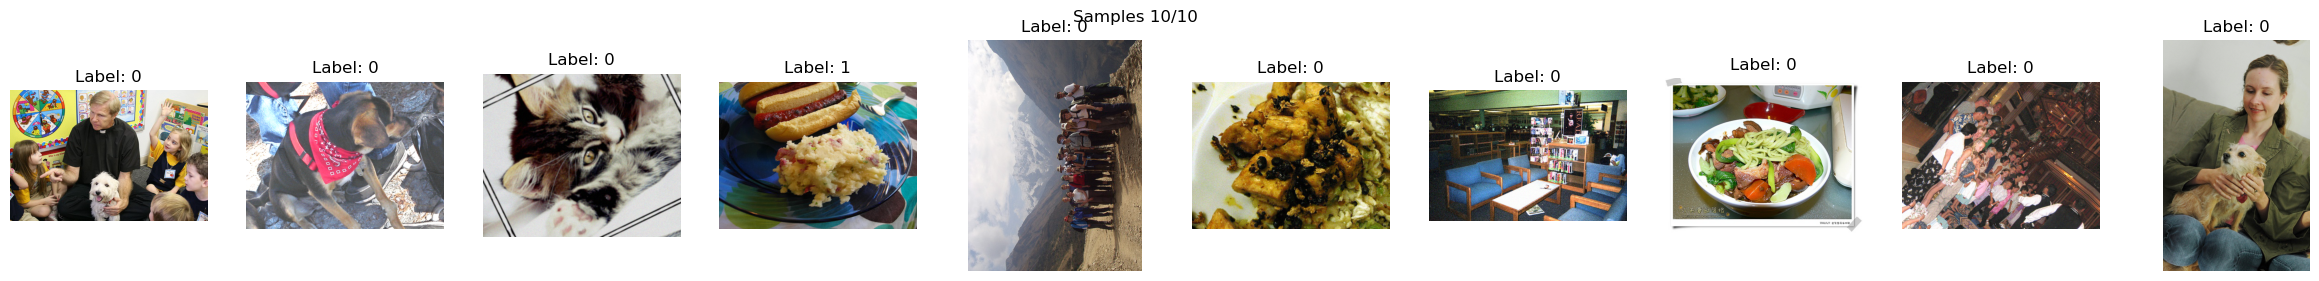

In [11]:
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)

visualize_samples(dataset, indices, "Samples")

In [12]:
batch_size = 4

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=batch_size)
test_loader_3 = torch.utils.data.DataLoader(test_dataset_3, batch_size=batch_size)

## Train models

In [69]:
params = {'lr': [1e-2, 1e-3, 1e-4],
          'wd': [1e-2, 1e-3, 1e-4, 1e-5],
          'gamma': [0.6, 0.8, 0.9]}

iterations = 5
best_model = None
best_val_f1 = 0
best_lr = None
best_wd = None
best_gamma = None

### ResNet50

In [12]:
torch.cuda.empty_cache()

In [13]:
for i in range(iterations):
    lr = choice(params['lr'])
    wd = choice(params['wd'])
    gamma = choice(params['gamma'])
    
    print(f'Iteration {i+1}/{iterations}: lr = {lr}, wd = {wd}, gamma = {gamma}')
    
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    # for param in model.parameters():
    #     param.requires_grad = False
        
    num_ft = model.fc.in_features
    
    model.fc = nn.Linear(num_ft, 2)
    model.to(device)
    model_params = model.fc.parameters()

    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': [param for name, param in model.state_dict().items()
                    if not 'fc' in name]},
        {'params': model_params, 'lr': lr, 'weight_decay': wd}],
                           lr=lr*1e-2, weight_decay=wd*1e-2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=gamma)
    loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 3, scheduler)
    f1_model = val_f1_history[-1]
    if f1_model> best_val_f1:
        best_val_f1 = f1_model
        best_model = model
        best_lr = lr
        best_wd = wd
        best_gamma = gamma

Iteration 1/5: lr = 0.0001, wd = 1e-05, gamma = 0.6
--Epoch 1/3, lr = 0.0001
----Average loss: 0.450962, Train accuracy: 0.785229, Val accuracy: 0.905435, Val f1 score: 0.855721
--Epoch 2/3, lr = 0.0001
----Average loss: 0.350052, Train accuracy: 0.845235, Val accuracy: 0.923913, Val f1 score: 0.883721
--Epoch 3/3, lr = 6e-05
----Average loss: 0.321014, Train accuracy: 0.863155, Val accuracy: 0.925000, Val f1 score: 0.880416
Iteration 2/5: lr = 0.01, wd = 0.0001, gamma = 0.6
--Epoch 1/3, lr = 0.01
----Average loss: 0.460809, Train accuracy: 0.854466, Val accuracy: 0.926087, Val f1 score: 0.871698
--Epoch 2/3, lr = 0.01
----Average loss: 0.494349, Train accuracy: 0.874016, Val accuracy: 0.939130, Val f1 score: 0.898551
--Epoch 3/3, lr = 0.006
----Average loss: 0.373189, Train accuracy: 0.886234, Val accuracy: 0.920652, Val f1 score: 0.874786
Iteration 3/5: lr = 0.0001, wd = 0.01, gamma = 0.8
--Epoch 1/3, lr = 0.0001
----Average loss: 0.462881, Train accuracy: 0.779528, Val accuracy: 0.8

In [ ]:
lr = best_lr
wd = best_wd
gamma = best_gamma

model = best_model

model_params = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': [param for name, param in model.state_dict().items()
                if not 'fc' in name]},
    {'params': model_params, 'lr': lr, 'weight_decay': wd}],
                    lr=lr*1e-2, weight_decay=wd*1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=gamma)
loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, scheduler)

In [18]:
torch.save(model.state_dict(), 'models_state_dict/resnet50.pth')

### Swin_t

In [74]:
for i in range(iterations):
    lr = choice(params['lr'])
    wd = choice(params['wd'])
    gamma = choice(params['gamma'])
    
    print(f'Iteration {i+1}/{iterations}: lr = {lr}, wd = {wd}, gamma = {gamma}')
    
    model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
        
    num_ft = model.head.in_features
    
    model.head = nn.Linear(num_ft, 2)
    model.to(device)
    model_params = model.head.parameters()

    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_params, lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=gamma)
    loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 3, scheduler)
    f1_model = val_f1_history[-1]
    if f1_model> best_val_f1:
        best_val_f1 = f1_model
        best_model = model
        best_lr = lr
        best_wd = wd
        best_gamma = gamma

Iteration 1/5: lr = 0.001, wd = 0.01, gamma = 0.6
--Epoch 1/3, lr = 0.001
----Average loss: 0.135383, Train accuracy: 0.957643, Val accuracy: 0.967391, Val f1 score: 0.948805
--Epoch 2/3, lr = 0.001
----Average loss: 0.091309, Train accuracy: 0.969318, Val accuracy: 0.970652, Val f1 score: 0.955519
--Epoch 3/3, lr = 0.0006
----Average loss: 0.085231, Train accuracy: 0.973120, Val accuracy: 0.971739, Val f1 score: 0.956811
Iteration 2/5: lr = 0.001, wd = 0.001, gamma = 0.8
--Epoch 1/3, lr = 0.001
----Average loss: 0.135922, Train accuracy: 0.959815, Val accuracy: 0.970652, Val f1 score: 0.956240
--Epoch 2/3, lr = 0.001
----Average loss: 0.091684, Train accuracy: 0.967689, Val accuracy: 0.972826, Val f1 score: 0.958541
--Epoch 3/3, lr = 0.0008
----Average loss: 0.086087, Train accuracy: 0.970948, Val accuracy: 0.971739, Val f1 score: 0.957237
Iteration 3/5: lr = 0.01, wd = 0.01, gamma = 0.9
--Epoch 1/3, lr = 0.01
----Average loss: 0.231181, Train accuracy: 0.942981, Val accuracy: 0.95869

In [80]:
lr = best_lr
wd = best_wd
gamma = best_gamma

model = best_model

model_params = model.head.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_params, lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=gamma)
loss_history, train_history, val_history, val_f1_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, scheduler)

--Epoch 1/10, lr = 0.001
----Average loss: 0.074176, Train accuracy: 0.976106, Val accuracy: 0.976087, Val f1 score: 0.964401
--Epoch 2/10, lr = 0.001
----Average loss: 0.076142, Train accuracy: 0.972577, Val accuracy: 0.976087, Val f1 score: 0.963696
--Epoch 3/10, lr = 0.001
----Average loss: 0.069818, Train accuracy: 0.973391, Val accuracy: 0.971739, Val f1 score: 0.957096
--Epoch 4/10, lr = 0.0008
----Average loss: 0.078811, Train accuracy: 0.972848, Val accuracy: 0.968478, Val f1 score: 0.952692
--Epoch 5/10, lr = 0.0008
----Average loss: 0.061461, Train accuracy: 0.978279, Val accuracy: 0.970652, Val f1 score: 0.955810
--Epoch 6/10, lr = 0.0008
----Average loss: 0.060640, Train accuracy: 0.977736, Val accuracy: 0.969565, Val f1 score: 0.954248
--Epoch 7/10, lr = 0.00064
----Average loss: 0.064047, Train accuracy: 0.975020, Val accuracy: 0.970652, Val f1 score: 0.955372
--Epoch 8/10, lr = 0.00064
----Average loss: 0.070286, Train accuracy: 0.972034, Val accuracy: 0.972826, Val f1 s

In [88]:
torch.save(model.state_dict(), 'models_state_dict/swin_t.pth')

## Load models

In [13]:
model_resnet50 = models.resnet50()
num_ft = model_resnet50.fc.in_features    
model_resnet50.fc = nn.Linear(num_ft, 2)
model_resnet50.to(device)
model_resnet50.load_state_dict(torch.load('models_state_dict/resnet50.pth'))

<All keys matched successfully>

In [14]:
model_swin_t = models.swin_t()
num_ft = model_swin_t.head.in_features    
model_swin_t.head = nn.Linear(num_ft, 2)
model_swin_t.to(device)
model_swin_t.load_state_dict(torch.load('models_state_dict/swin_t.pth'))

<All keys matched successfully>

## Predictions

### ResNet50

#### On sourse data:
- Public - 0.914
- Privat - 0.919

#### With augmentation:
- Public - 0.918
- Privat - 0.916

In [59]:
prediction_resnet50_1, img_id = evaluate_model(model_resnet50, test_loader)
prediction_resnet50_2, img_id = evaluate_model(model_resnet50, test_loader_2)
prediction_resnet50_3, img_id = evaluate_model(model_resnet50, test_loader_3)

In [65]:
prediction_resnet50 = np.round(np.count_nonzero(np.array([prediction_resnet50_1, prediction_resnet50_2, prediction_resnet50_3]), axis=0) / 3).astype(int)

In [66]:
with open('submissions/submission_resnet50.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(img_id, prediction_resnet50))

### Swin_t
#### On sourse data:
- Public - 0.953
- Privat - 0.958

#### With augmentation:
- Public - 0.957
- Privat - 0.961

In [18]:
prediction_swin_t_1, img_id = evaluate_model(model_swin_t, test_loader)

In [ ]:
prediction_swin_t_2, img_id = evaluate_model(model_swin_t, test_loader_2)
prediction_swin_t_3, img_id = evaluate_model(model_swin_t, test_loader_3)

In [21]:
prediction_swin_t = np.round(np.count_nonzero(np.array([prediction_swin_t_1, prediction_swin_t_2, prediction_swin_t_3]), axis=0) / 3).astype(int)

In [22]:
with open('submissions/submission_swin_t.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(img_id, prediction_swin_t))